In [1]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay 

# %run ./jlu_preprocessing.ipynb

## Reading Data

Original Data

In [2]:
original_data = pd.read_excel('global_warming_tweets.xls')
print(original_data.shape)
original_data.drop(columns=["existence.confidence"], inplace=True)
original_data.drop_duplicates(subset=["tweet"], inplace=True)

data = original_data

print(data.shape)
data.head()

(6090, 3)
(5541, 2)


,tweet,existence
0,Global warming report urges governments to act...,Yes
1,Fighting poverty and global warming in Africa ...,Yes
2,Carbon offsets: How a Vatican forest failed to...,Yes
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,Yes
5,RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness...,Yes


Web Scraped Data

In [3]:
# rawScrapedTweets = []

# with open("scrapedTweets.txt") as fh:
#     d = fh.read()
#     rawScrapedTweets = d.split('\n')

# scrapedTweets = pd.DataFrame(rawScrapedTweets, columns=["tweets"])

# print(scrapedTweets.shape)
# scrapedTweets.head()

## Data Exploration

<BarContainer object of 3 artists>

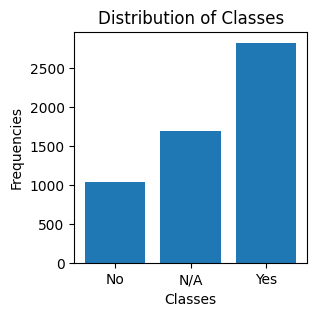

In [4]:
size = len(data["existence"])
cnt = [0, 0, 0]

for val in data["existence"]:
    if val == "N" or val == "No":
        cnt[0] += 1
    elif pd.isnull(val):
        cnt[1] += 1
    elif val == "Yes" or val == "Y":
        cnt[2] += 1

plt.figure(figsize=(3,3))
plt.xticks(np.arange(3), ["No", "N/A", "Yes"])
plt.xlabel("Classes")
plt.ylabel("Frequencies")
plt.title("Distribution of Classes")
plt.bar(np.arange(3), cnt)

Running Algorithms

> I borrowed Vennela's word cloud generation code and ran it again with my new preprocessing to get more accurate results.

In [146]:
from itertools import chain
from wordcloud import WordCloud, STOPWORDS 

def generateWordCloud(tweets):
    allwords = " ".join(set(chain.from_iterable(tweets)))
    wordcloud = WordCloud(width = 600, height = 600, 
                    background_color ='white', 
                    stopwords = set(STOPWORDS), 
                    min_font_size = 10).generate(allwords)

    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.figure(figsize = (7, 7), facecolor = 'white', edgecolor='blue') 
    plt.imshow(wordcloud) 

    plt.show()

In [147]:
def genCloud(data, fn):
    data = data[data["existence"].apply(fn)]
    tweets = data['tweet']

    # Convert all to lowercase
    tweets = [splitWords(t) for t in tweets]

    # Process tweets through spaCy pipeline
    tweets, indices = spacyPipeline(tweets)
    generateWordCloud(tweets)

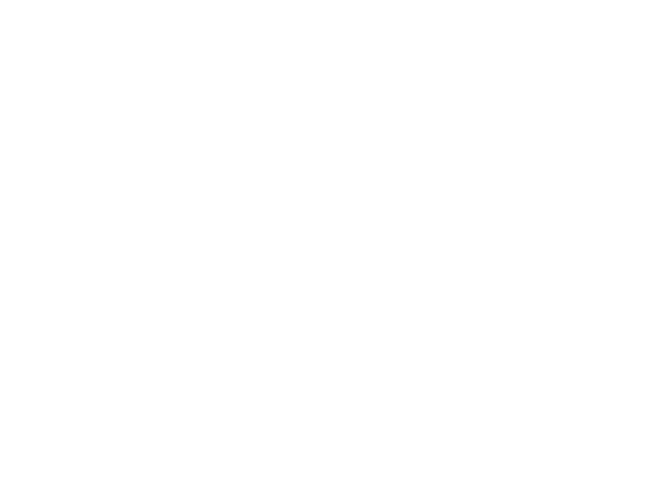

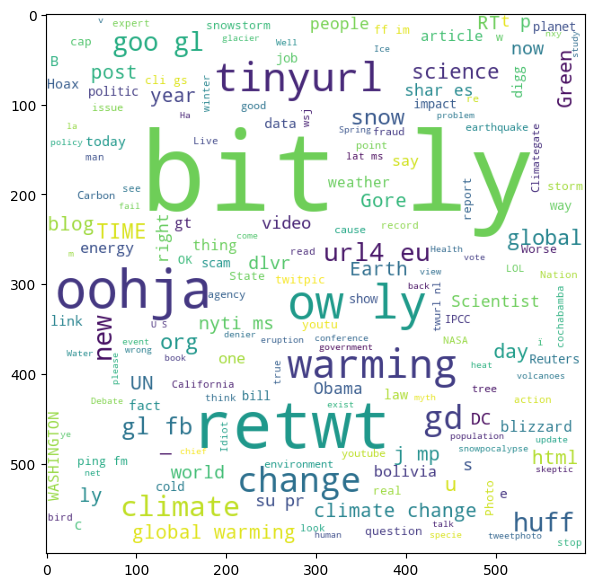

In [168]:
generateWordCloud([t.split(' ') for t in original_data['tweet']])

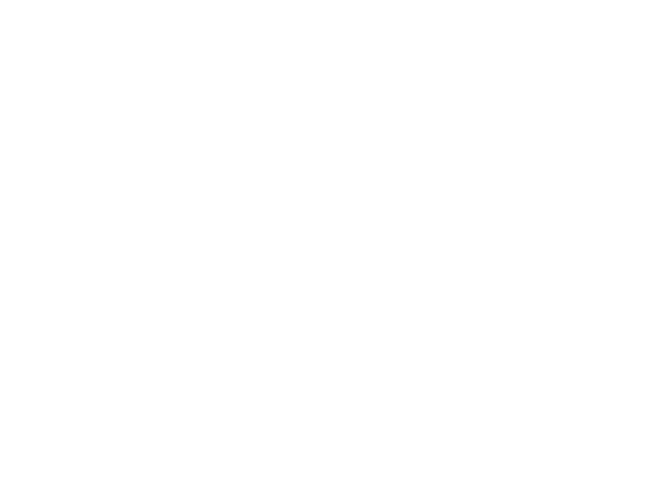

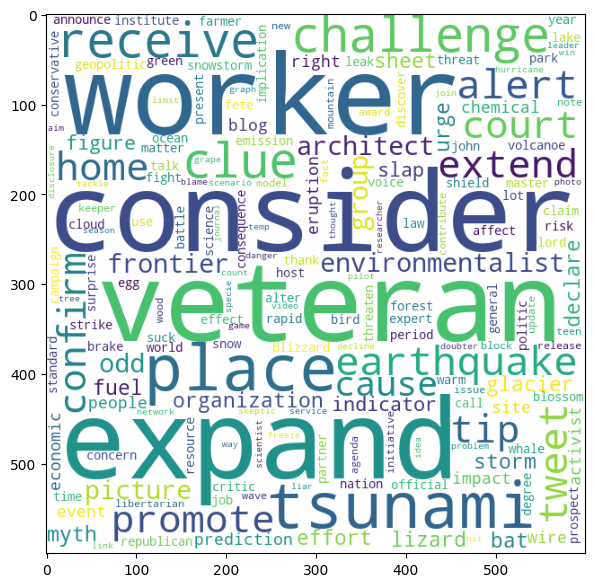

In [165]:
genCloud(original_data, lambda x: x in ["Yes", "Y"])

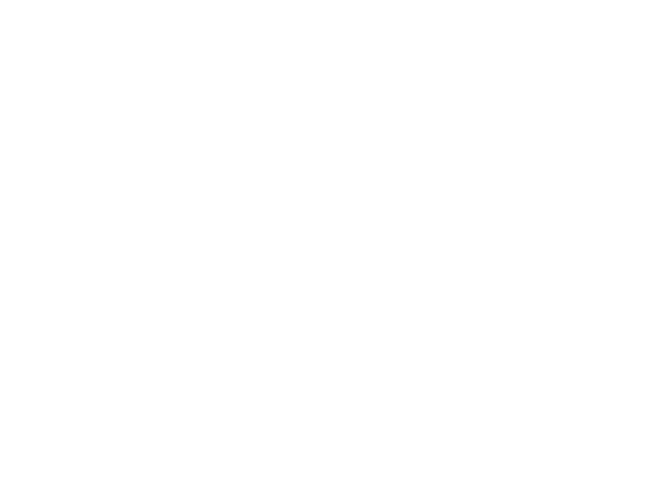

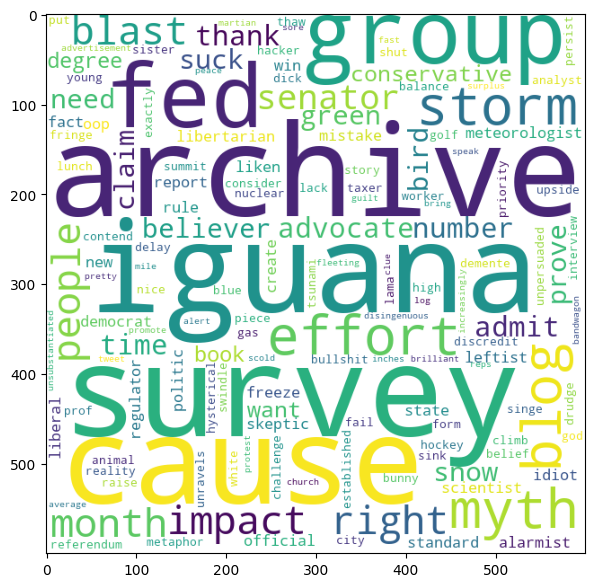

In [166]:
genCloud(data, lambda x: x in ["No", "N"])

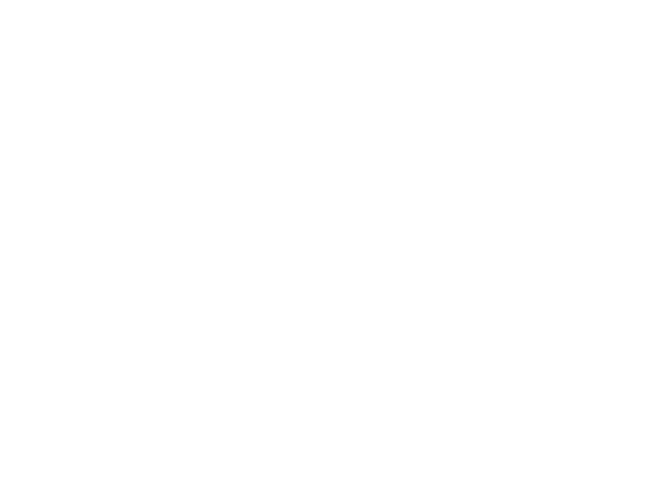

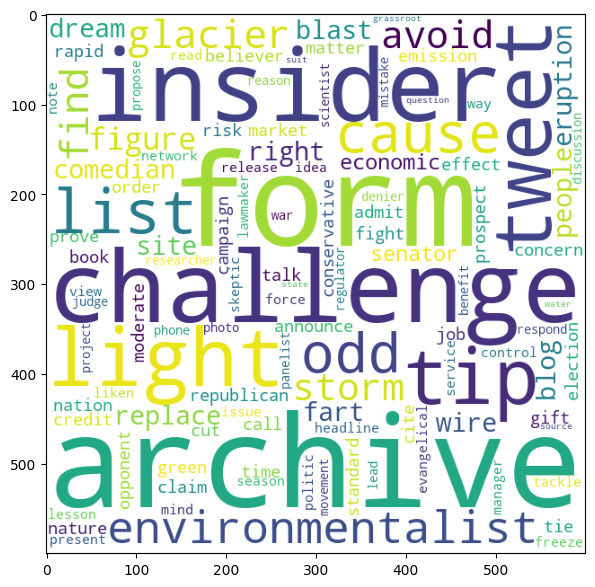

In [167]:
genCloud(data, lambda x: pd.isnull(x))

## Functions

In [6]:
def cross_val(X_train, Y_train, X_test, Y_test, model, folds=10):
    scoring = ["accuracy", "precision", "recall", "f1_macro"]
    cv = cross_validate(model, X_train, Y_train, cv=folds, return_train_score=True, scoring=scoring, n_jobs=-1)
    
    train_scores = []
    test_scores = []
    
    for metric in scoring:
        train_scores.append(np.mean(cv[f"train_{metric}"]))
        test_scores.append(np.mean(cv[f"test_{metric}"]))
        
    mean_scores = pd.DataFrame((train_scores, test_scores), columns=scoring, index=["train", "test"])
    
    return cv, mean_scores

Source: https://stackoverflow.com/questions/27016904/matplotlib-legends-in-subplot

In [7]:
def plot_cross_val(cv, folds=10):    
    metrics = ["accuracy", "precision", "recall"]
    colors = ["r", "g", "b", "y"]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    
    for index, time_ in enumerate(["train", "test"]):
        for num, metric in enumerate(metrics):
            indexer = f"{time_}_{metric}"
            ax[index].plot(np.arange(folds), cv[indexer], color=colors[num])
        
        ax[index].legend(metrics, loc="upper left")
        ax[index].title.set_text(f"Scores during {time_} time")
    
    plt.tight_layout()
    plt.show()

Sources: 
- https://stackoverflow.com/questions/61325314/how-to-change-plot-confusion-matrix-default-figure-size-in-sklearn-metrics-packa
- https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix

In [8]:
def pred(X_train, Y_train, X_test, Y_test, model):
    clf = model.fit(X_train, Y_train)
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    
    conf_mat = confusion_matrix(y_true=Y_train, y_pred=pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    disp.plot(ax=ax1)    
    disp.ax_.set_title("Train Time")
    
    conf_mat2 = confusion_matrix(y_true=Y_test, y_pred=pred2)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_mat2)
    disp2.plot(ax=ax2)
    disp2.ax_.set_title("Test Time")
      

## Testing

Preprocessing

> Note: I am combining the "No" and "N/A" classes together into one.

In [3]:
%run ./jlu_preprocessing.ipynb

X, Y = preprocess(data, verbose=False)
X

<5305x4364 sparse matrix of type '<class 'numpy.float64'>'
	with 39267 stored elements in Compressed Sparse Row format>

In [4]:
X_ = TruncatedSVD(n_components=2500).fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_, Y, test_size=0.2)

Testing

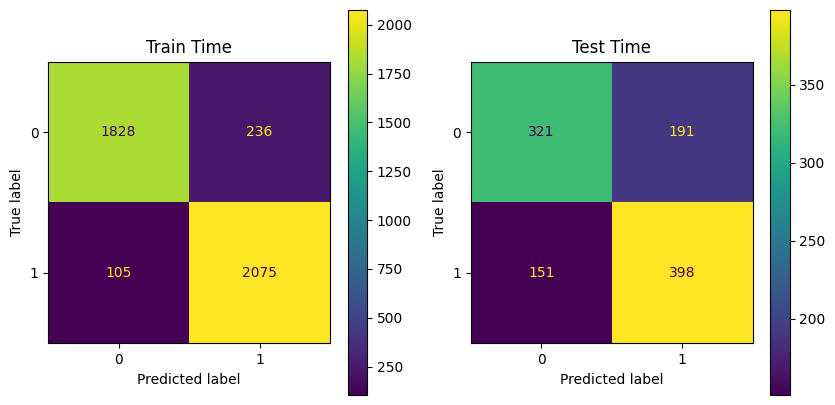

In [13]:
model = pred(X_train, Y_train, X_test, Y_test, Perceptron())

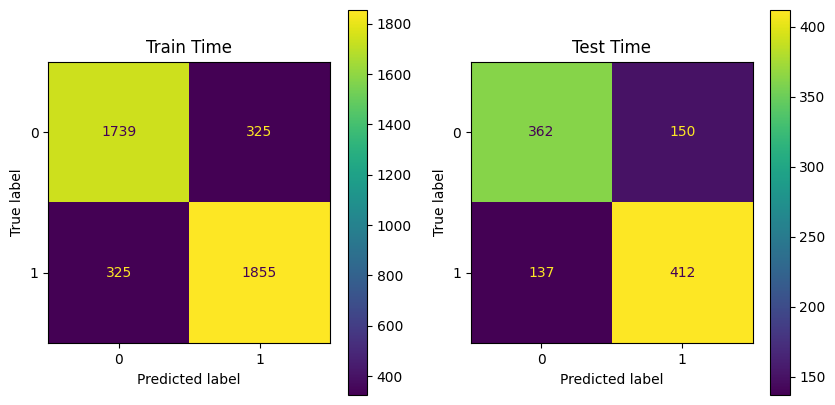

In [14]:
model = pred(X_train, Y_train, X_test, Y_test, LogisticRegression())

Cross Validation

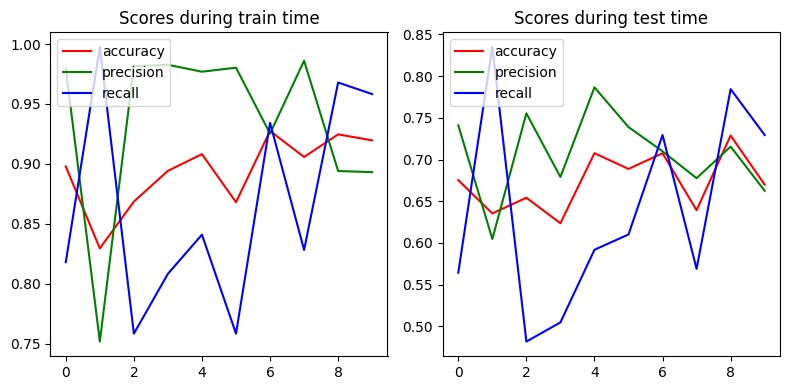

,accuracy,precision,recall,f1_macro
train,0.894385,0.935152,0.867023,0.893296
test,0.672974,0.707090,0.639908,0.668512


In [15]:
cv_perceptron, mean_scores_perceptron = cross_val(X_train, Y_train, X_test, Y_test, Perceptron())
plot_cross_val(cv_perceptron)
mean_scores_perceptron

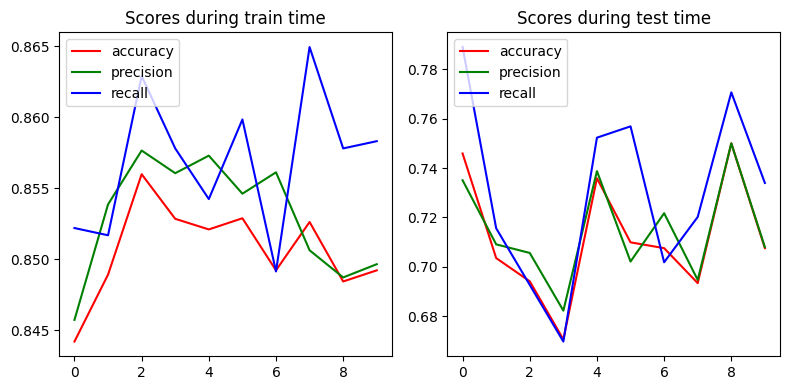

,accuracy,precision,recall,f1_macro
train,0.850639,0.853029,0.856881,0.850505
test,0.711836,0.714720,0.730275,0.711330


In [16]:
cv_lr, mean_scores_lr = cross_val(X_train, Y_train, X_test, Y_test, LogisticRegression())
plot_cross_val(cv_lr)
mean_scores_lr

Testing SVD

In [113]:
def testSVD(X, Y, n_components):
    X_ = TruncatedSVD(n_components=n_components).fit_transform(X)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_, Y, test_size=0.2)

    model = LogisticRegression()

    num_cv = 5
    
    cv = cross_validate(model, X_train, Y_train, cv=num_cv, return_train_score=True, n_jobs=-1)
    
    return np.sum(cv["test_score"])/num_cv

1000  |  0.7082961086294641
2000  |  0.7087622508167211
3000  |  0.6974548303220215
4000  |  0.7075852279040825


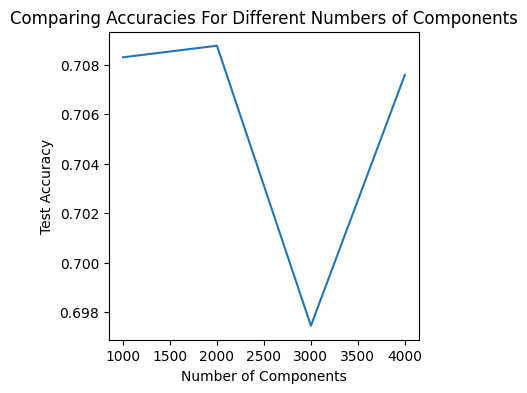

In [115]:
X_svd_test, Y_svd_test = preprocess(data)
components = np.arange(1000,X_svd_test.shape[0]-(X_svd_test.shape[0]%1000),1000)
scores = []
for num in components:
    score = testSVD(X_svd_test, Y_svd_test, num)
    scores.append(score)
    
    print(num, " | ", score)
    
plt.figure(figsize=(4,4))
plt.plot(components, scores)
plt.ylabel("Test Accuracy")
plt.xlabel("Number of Components")
plt.title("Comparing Accuracies For Different Numbers of Components")
plt.show()

Plot for Differing Numbers of Samples

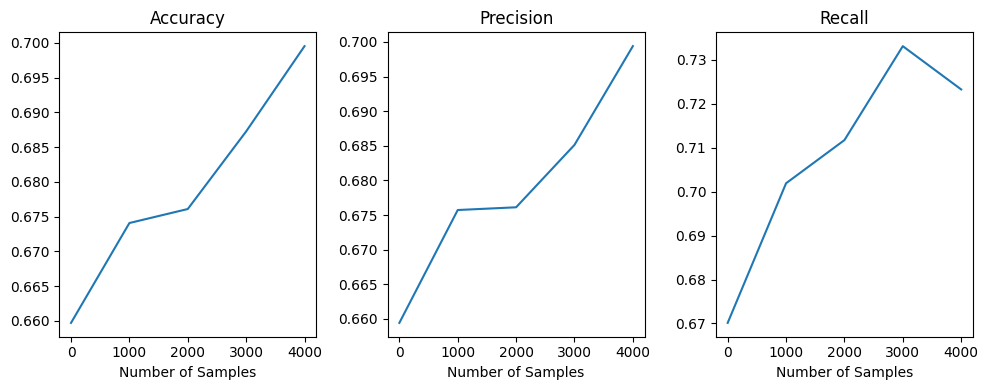

In [131]:
size = X.shape[0]
inc = 1000

samples = np.arange(0, size-(size%inc), inc)
acc_scores = []
prec_scores = []
rec_scores = []

original_data_ = data
for i in range(0, size-(size%inc), inc):
    data = original_data_.sample(n=i + inc, replace=False, axis=0)
    X_sampled, Y_sampled = preprocess(data)
    X_train_, X_test_, Y_train_, Y_test_ = train_test_split(X_sampled, Y_sampled, test_size=0.2)
    cv_lr, mean_scores_lr = cross_val(X_train_, Y_train_, X_test_, Y_test_, LogisticRegression())
    acc_scores.append(mean_scores_lr.loc["test","accuracy"])
    prec_scores.append(mean_scores_lr.loc["test","precision"])
    rec_scores.append(mean_scores_lr.loc["test","recall"])    

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

sampling_scores = [acc_scores, prec_scores, rec_scores]
labels = ["Accuracy", "Precision", "Recall"]

for i in range(3):
    ax[i].plot(samples, sampling_scores[i])
    ax[i].set_title(labels[i])
    ax[i].set_xlabel("Number of Samples")

plt.tight_layout()
plt.show()